# PART 1: Ridge Regression

This part involves comparison of two methodologies of ridge regression implementation, and their performance with different regularisation threshold values. The two methods used are the **closed-form solution** and **Stochastic Gradient Descent (SGD) Regression**.

In [549]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import warnings

Below are the helper functions I am using for *visualisation* and *dataset generations*

In [550]:
#This function produces a scatterplot of just 1 set of values.
def plot(x, y, title=None):
    plt.figure(figsize=(4, 3))
    plt.scatter(x, y, color='red', s=3) 
    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.show()

#This function produces a comparative scatterplot of 2 sets of values (actual vs. predicted)
def plot_comparison(values1, values2, title=None):
    plt.figure(figsize=(4, 3))
    plt.scatter(values1[0], values1[1], color='red', label='Actual Values', s=3) 
    plt.scatter(values2[0], values2[1], color='blue', label='Predicted Values',s =3) 

    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

    #This function produces a comparative scatterplot of 3 sets of values (actual vs. predicted Model 1 vs. predicted Model 2)
def plot_comparison_threeways(values1, values2, values3, model1title, model2title, title=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(values1[0], values1[1], color='red', label='Actual Values', s=7) 
    plt.scatter(values2[0], values2[1], color='blue', label='Predicted Values from ' + model1title , s=7) 
    plt.scatter(values3[0], values3[1], color='green', label='Predicted Values from ' + model2title , s=7) 
    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

# Generation of random toy datasets based on degree & n_samples
# Based on provided function
def generate_polynomial_dataset(degree, n_samples):
    X = np.random.uniform(-5, 5, n_samples).reshape(-1, 1)
    y = []
    for xi in X:
        sum = 0
        for ki in range(degree + 1):
            ak = np.random.uniform(0, 1)
            term = ak * (xi ** ki)
            sum += term
        e = np.random.normal(0, 1)
        yi = sum + e
        y.append(yi)
    return X, y

The below code block shows first the generation of toy datasets. The code outputs 3 plots displaying values of the generated data demonstrating the utility of the plot generation.
Next, it shows the pre-processing of data. I chose to introduce three steps of pre-processing: <br>
<br>1: Addition of polynomial features for quadratic and cubic datasets. This allows linear relationships to be formed from x^2 and x^3 respectively to y
<br>2: Scale normalisation of quadratic and cubic features, to ensure feature distance is normalised with respect to distance from the mean
<br>3: Partitioning of data into 80% training data and 20% testing data, to ensure some unseen data is set aside for validaiton of the model

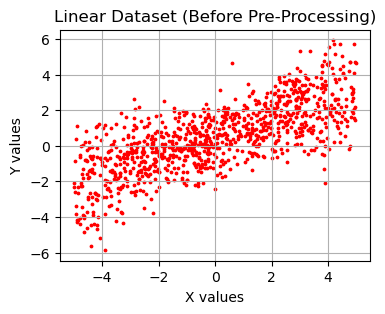

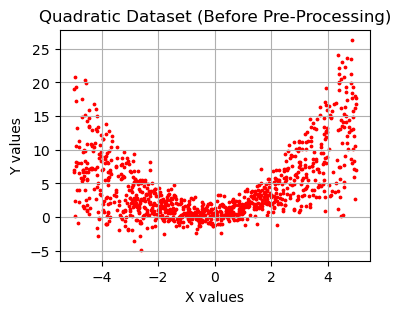

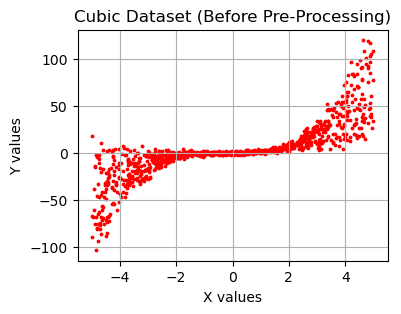

In [551]:
X_linear, y_linear = generate_polynomial_dataset(1, 1000)
X_quad, y_quad = generate_polynomial_dataset(2, 1000)
X_cubic, y_cubic = generate_polynomial_dataset(3, 1000)

plot(X_linear, y_linear, "Linear Dataset (Before Pre-Processing)")
plot(X_quad, y_quad, "Quadratic Dataset (Before Pre-Processing)")
plot(X_cubic, y_cubic, "Cubic Dataset (Before Pre-Processing)")

#Addition of polynomial features
X_quad = np.hstack((X_quad, X_quad**2))
X_cubic = np.hstack((X_cubic, X_cubic**2, X_cubic**3))

#Scale normalisation
X_quad = StandardScaler().fit_transform(X_quad)
X_cubic = StandardScaler().fit_transform(X_cubic)

#Splitting 80/20 into training and testing sets
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.2)
X_quad_train, X_quad_test, y_quad_train, y_quad_test = train_test_split(X_quad, y_quad, test_size=0.2)
X_cubic_train, X_cubic_test, y_cubic_train, y_cubic_test = train_test_split(X_cubic, y_cubic, test_size=0.2)

## Closed Form Ridge Regression

This form of regression is the first form of regression implemented in the project. This implementation uses the closed-form solution  with harnessing the vectorised NumPy algorithm. 

In [552]:
ALPHA_CHOICES = [0, 0.1, 100] #The 3 designated values that will be tested for 'alpha'


# Custom implemented Closed Form Ridge Regression
class RidgeRegression_ClosedForm():
    def __init__(self, alpha = 0.5):
        self.alpha = alpha
        self.weights = None

    def train(self, X, y):
        X = np.insert(X, X.shape[1], 1, axis=1)
        biased_i = np.identity(len(X[0]))
        biased_i[0,0] = 0
        XT = np.transpose(X)
        self.weights = np.linalg.inv((XT @ X) + self.alpha * biased_i) @ XT @ y

    def predict(self, X):
        X = np.insert(X, X.shape[1], 1, axis=1)
        return X @ self.weights

The code below completes a Closed Form Ridge Regression for each of the linear, quadratic and cubic datasets. For each, trial the different alpha parameter values of 0, 0.1 and 100 (as specified), and plot their performance

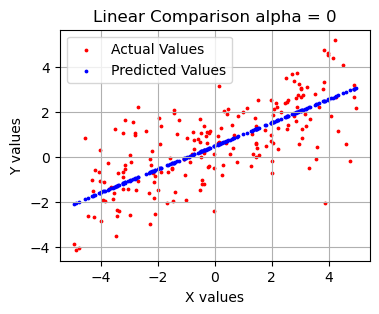

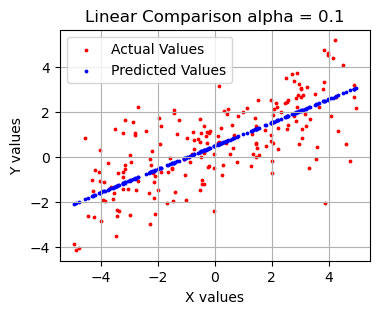

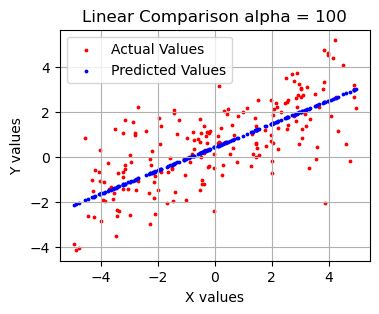

In [553]:
predicted_y_list_cf = [] # This list is being created for later comparison with the other regression model

for alpha in ALPHA_CHOICES:
    linear_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    linear_reg_cf.train(X_linear_train, y_linear_train)
    y_linear_predicted = linear_reg_cf.predict(X_linear_test)
    predicted_y_list_cf.append(y_linear_predicted)
    plot_comparison([X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted], f'Linear Comparison alpha = {alpha}')

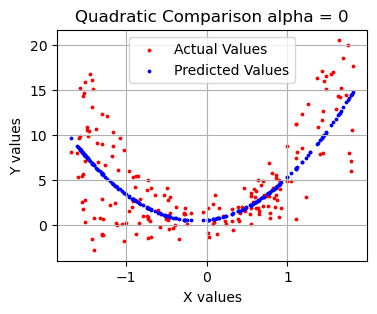

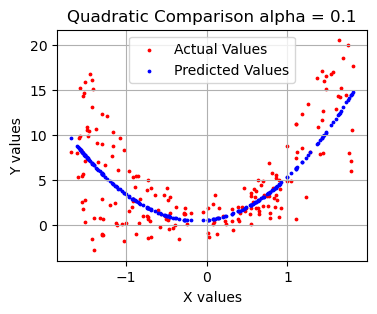

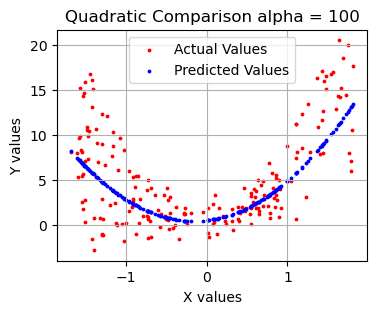

In [554]:
for alpha in ALPHA_CHOICES:
    quad_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    quad_reg_cf.train(X_quad_train, y_quad_train)
    y_quad_predicted = quad_reg_cf.predict(X_quad_test)
    predicted_y_list_cf.append(y_quad_predicted)
    plot_comparison([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted], f'Quadratic Comparison alpha = {alpha}')

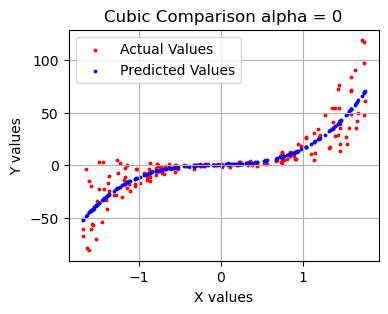

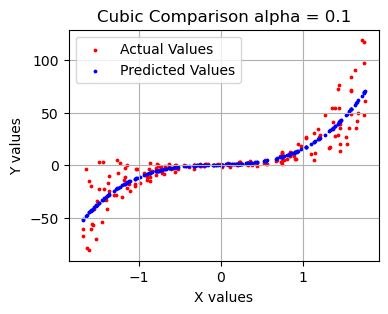

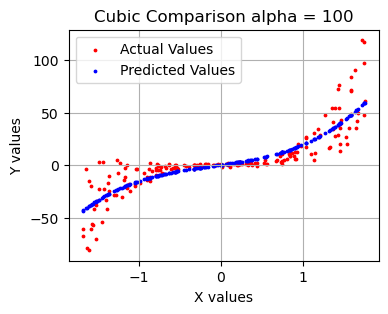

In [555]:
for alpha in ALPHA_CHOICES:
    cubic_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    cubic_reg_cf.train(X_cubic_train, y_cubic_train)
    y_cubic_predicted = cubic_reg_cf.predict(X_cubic_test)
    predicted_y_list_cf.append(y_cubic_predicted)
    plot_comparison([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted], f'Cubic Comparison alpha = {alpha}')

## SGD Regression

The following code runs a SGD Regression model on the same linear, quadratic and cubic datasets. It similarly trials different alpha parameter values and visualises the results.

In [556]:
MAX_ITERATIONS = 1000 # Chosen to optimise computation time and solution accuracy
predicted_y_list_SGD = [] # Used for eventual comparison with Closed Form Regressions done on same dataset
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn") # Ignore non-problematic errors

#Function for creating SGDRegressor object, training and predicting it. It returns the predicted (y) value list
def predict_SGDReg(X, Y, X_test, alpha):
    sgd_reg = SGDRegressor(penalty='l2', alpha=alpha, max_iter=MAX_ITERATIONS)
    sgd_reg.fit(X, Y)
    return sgd_reg.predict(X_test)

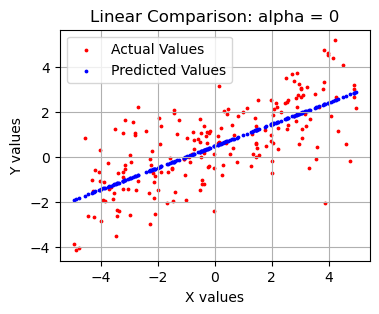

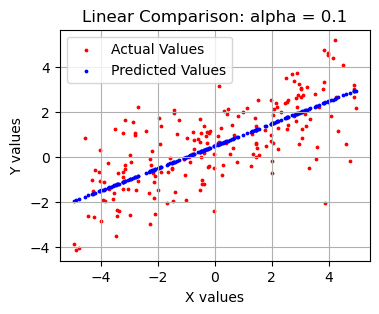

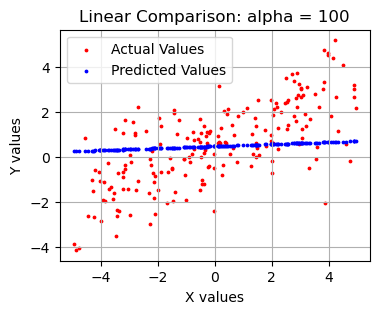

In [557]:
for i, alpha in enumerate(ALPHA_CHOICES):
    y_linear_predicted = predict_SGDReg(X_linear_train, y_linear_train, X_linear_test, alpha)
    predicted_y_list_SGD.append(y_linear_predicted)
    plot_comparison([X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted], f'Linear Comparison: alpha = {alpha}')
    

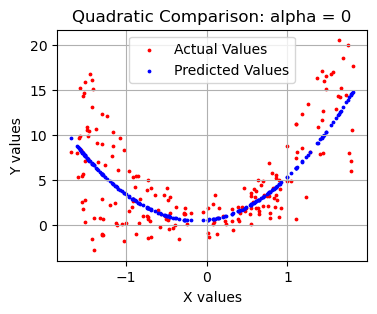

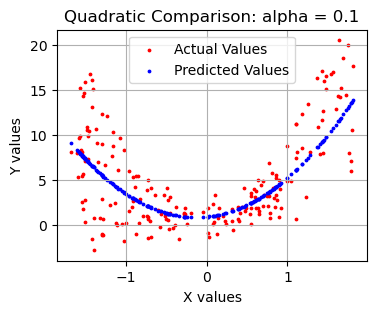

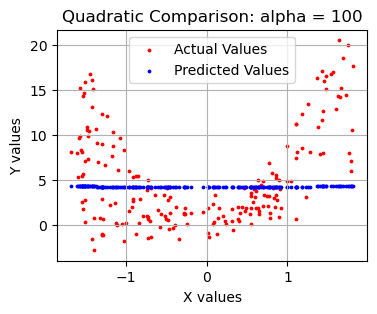

In [558]:
for i, alpha in enumerate(ALPHA_CHOICES):
    y_quad_predicted = predict_SGDReg(X_quad_train, y_quad_train, X_quad_test, alpha)
    predicted_y_list_SGD.append(y_quad_predicted)
    plot_comparison([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted], f'Quadratic Comparison: alpha = {alpha}')


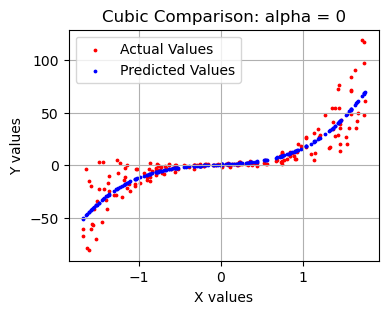

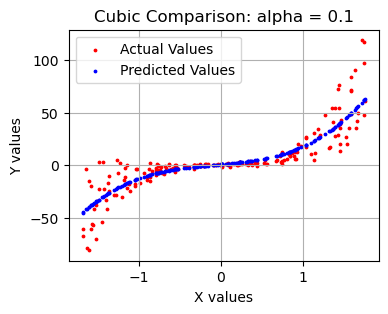

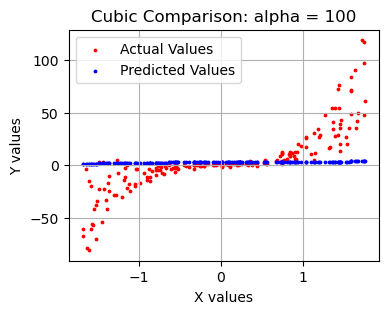

In [559]:
for i, alpha in enumerate(ALPHA_CHOICES):
    y_cubic_predicted = predict_SGDReg(X_cubic_train, y_cubic_train, X_cubic_test, alpha)
    predicted_y_list_SGD.append(y_cubic_predicted)
    plot_comparison([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted], f'Cubic Comparison: alpha = {alpha}')
    

#### Compare the models of regression on linear, quadratic and cubic datasets for each of the three alpha parameters 

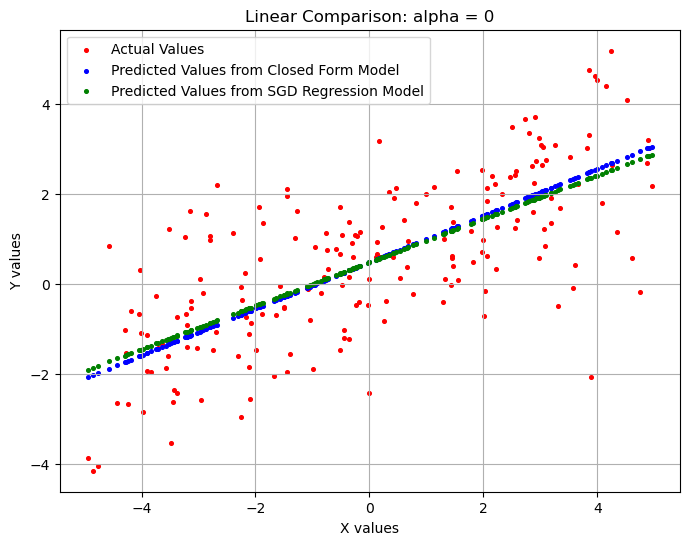

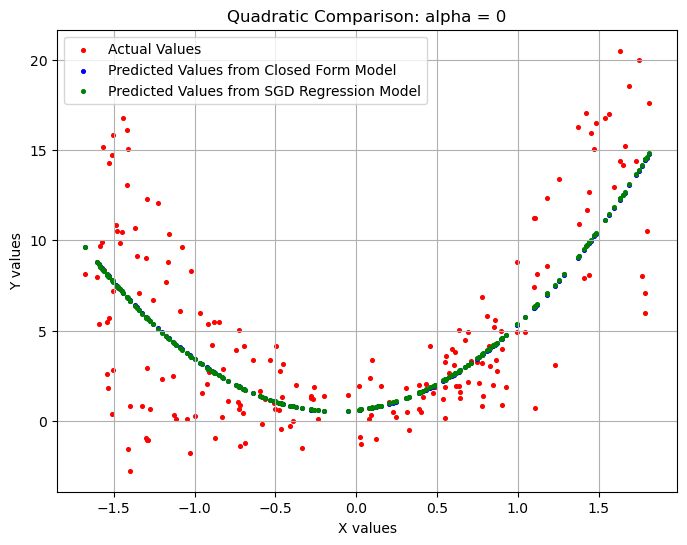

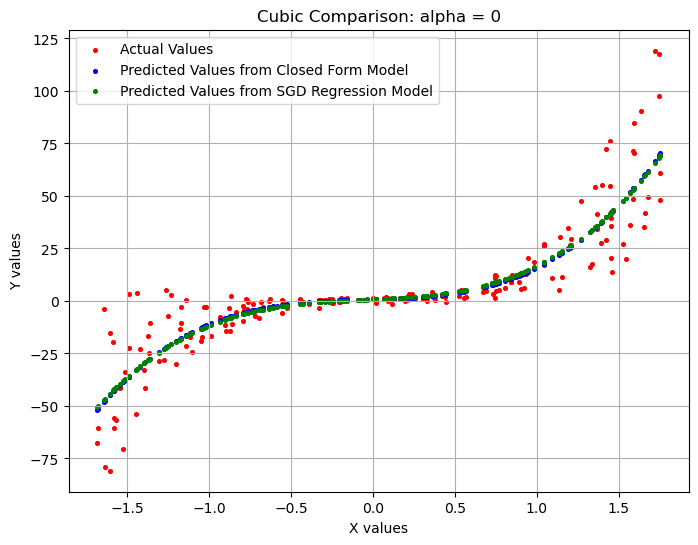

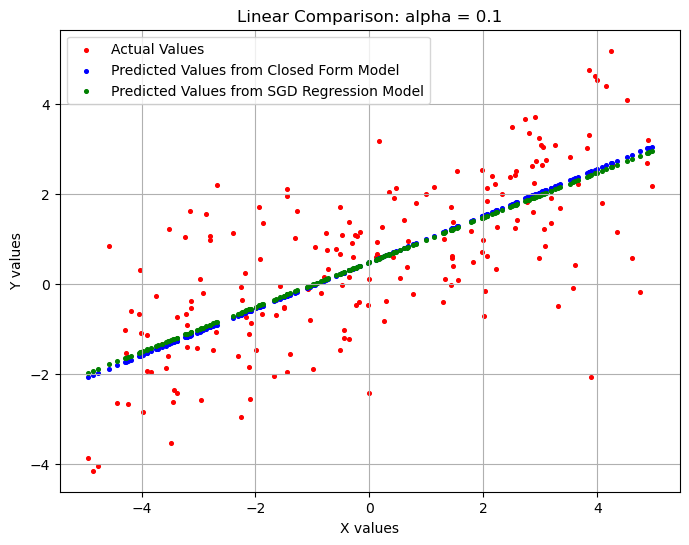

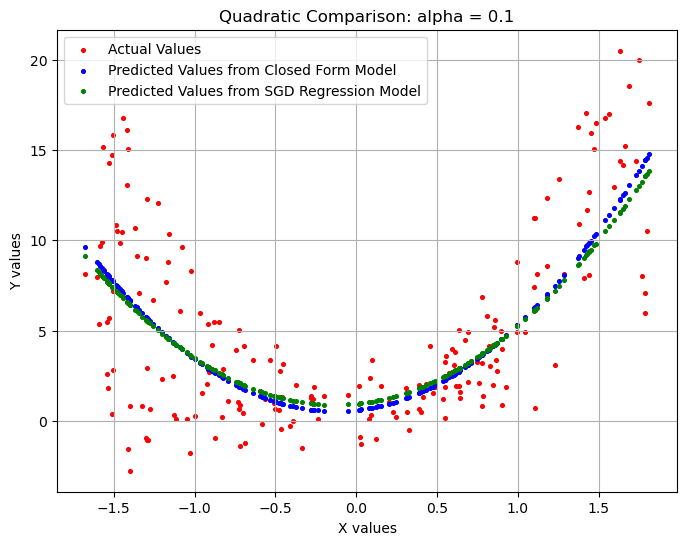

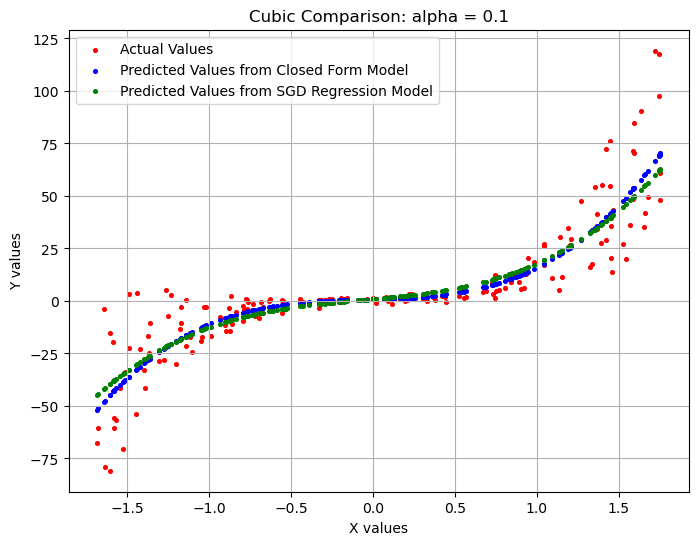

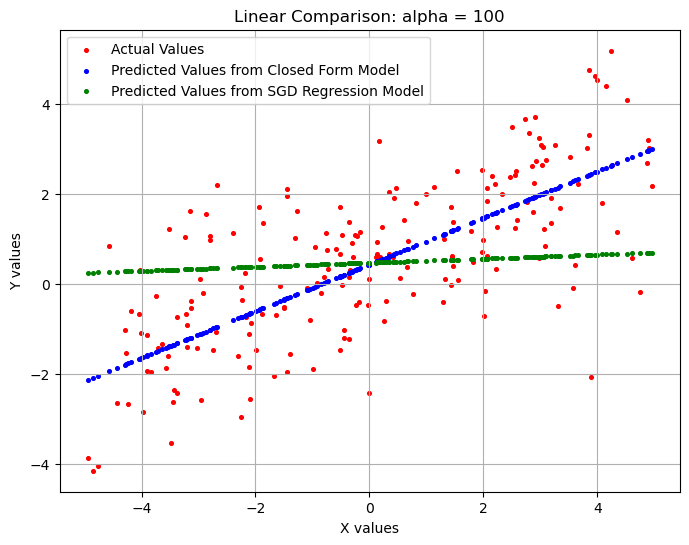

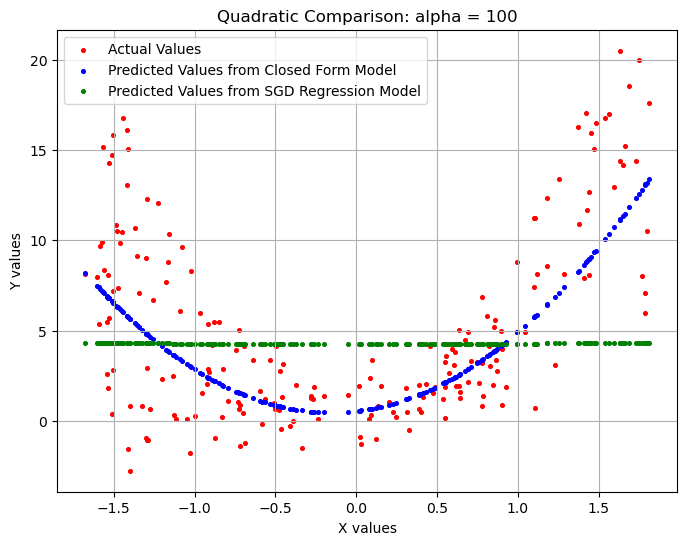

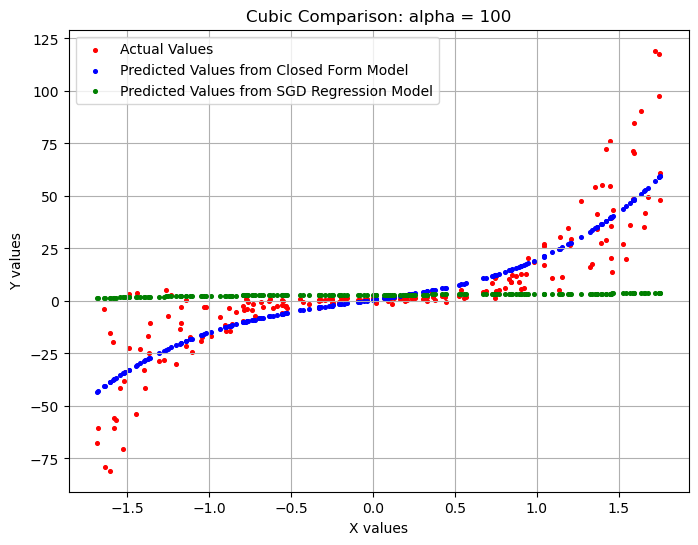

In [560]:
for i in range(3):
    plot_comparison_threeways([X_linear_test, y_linear_test], [X_linear_test, predicted_y_list_cf[i]], [X_linear_test, predicted_y_list_SGD[i]], 'Closed Form Model','SGD Regression Model',f'Linear Comparison: alpha = {ALPHA_CHOICES[i]}')
    plot_comparison_threeways([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], predicted_y_list_cf[3+i]], [X_quad_test[:,0], predicted_y_list_SGD[3+i]], 'Closed Form Model','SGD Regression Model',f'Quadratic Comparison: alpha = {ALPHA_CHOICES[i]}')
    plot_comparison_threeways([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], predicted_y_list_cf[6+i]], [X_cubic_test[:,0], predicted_y_list_SGD[6+i]], 'Closed Form Model','SGD Regression Model',f'Cubic Comparison: alpha = {ALPHA_CHOICES[i]}')

## Results Analysis:

<br>(a) For the sklearn SGDRegressor model, I had the choice of a number of parameters. I first opted to set alpha to whatever the trialled value of alpha was (0, 0.1 or 100) for regularisation. Next, I set the max iterations to a value that could provide a balance between runtime and obtaining an accurate prediction in 1000. Finally, I chose to set the loss function to L2 regularization: which implements Ridge regression. This loss function was chosen as it was the same as the one implemented above, and allows a fair comparison of models to be made

<br>(b) Plots of the datasets, the individual performance of the closed form model and the SGDRegressor model, and finally of comparisons between the two models can be found above. The weights array w can be seen to have a greater magnitude when the regularisation parameter is lower, and move closer to the mean when the parameter is higher.

<br>(c) The main difference noticeable between the models is the handling of high values of alpha. The SGDRegressor underfits severely when faced with high alpha values (such as alpha=100), leading to very innacurate regressions. Meanwhile, the closed-form based model is able to handle these values, still producing consistent accurate predictions regardless of alpha. The SGDRegressor penalises weight arrays with high magnitudes of w, leading to this underfitting, while linear regression doesn't use regularisation in this way, instead finding the exact solution to its closed form equation.

## Experimentation:

First we will test both models on higher polynomial degrees, with a fixed value of alpha=0.1.

Next we will fix the degree of both model datasets to 3 for an accurate comparison, remain alpha at 0.1, and experiment with larger values of n_samples.

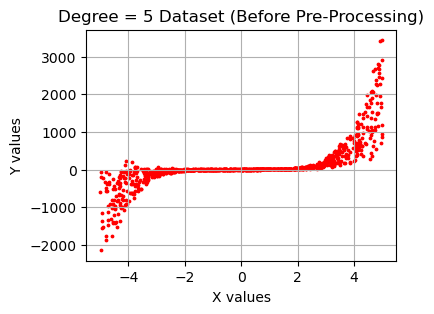

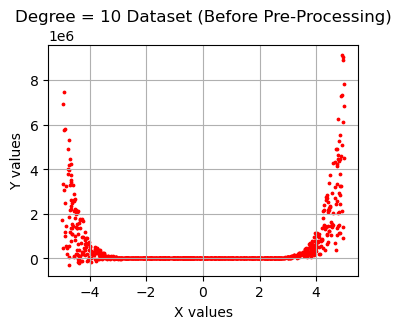

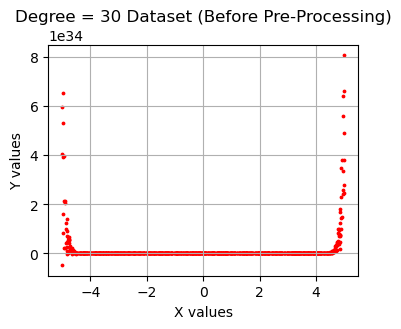

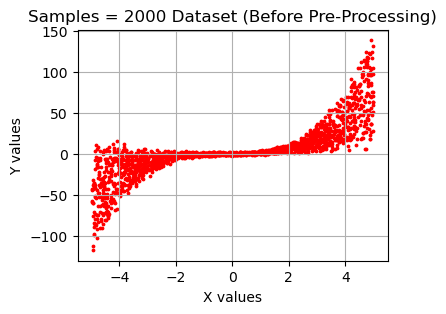

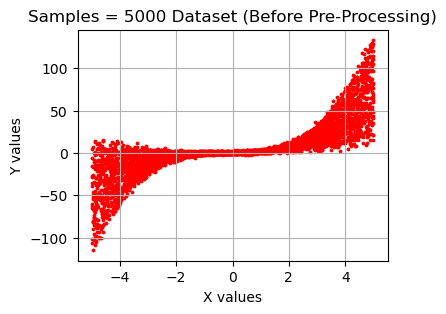

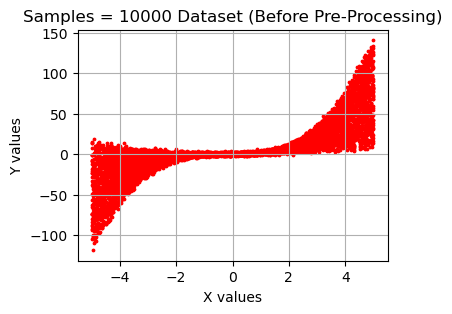

In [561]:
dataset_variations = [(5, 1000), (10,1000), (50,1000), (3,2000), (3,5000), (3,10000)]
dataset_descriptions = ["Degree = 5", "Degree = 10", "Degree = 30", "Samples = 2000", "Samples = 5000", "Samples = 10000"]
X_list = [None] * 6
y_list = [None] * 6
X_train_list = [None] * 6
X_test_list = [None] * 6
y_train_list = [None] * 6
y_test_list = [None] * 6

for i, dataset_params in enumerate(dataset_variations):

    X_list[i], y_list[i] = generate_polynomial_dataset(dataset_params[0], dataset_params[1])
    plot(X_list[i], y_list[i], f'{dataset_descriptions[i]} Dataset (Before Pre-Processing)') #Visualisation of dataset
    X_list[i] = np.hstack((X_list[i], X_list[i]**dataset_params[0])) #Addition of polynomial features
    X_list[i] = StandardScaler().fit_transform(X_list[i]) #Scale normalisation
    X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i] = train_test_split(X_list[i], y_list[i], test_size=0.2) #Splitting 80/20 into training and testing sets


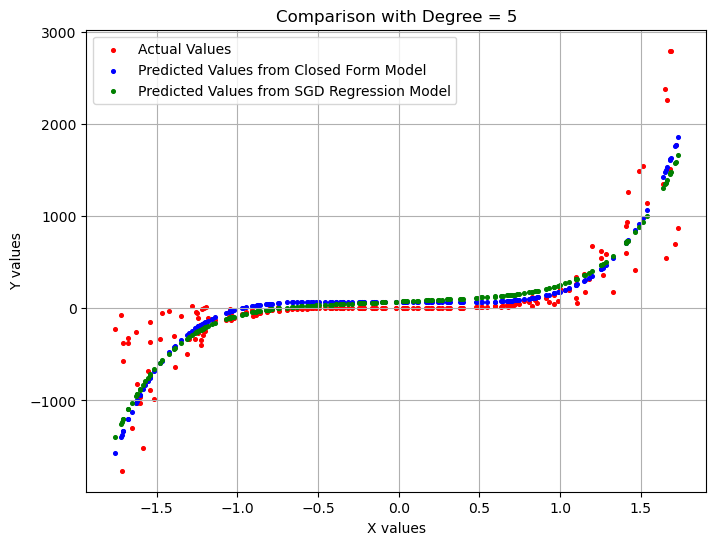

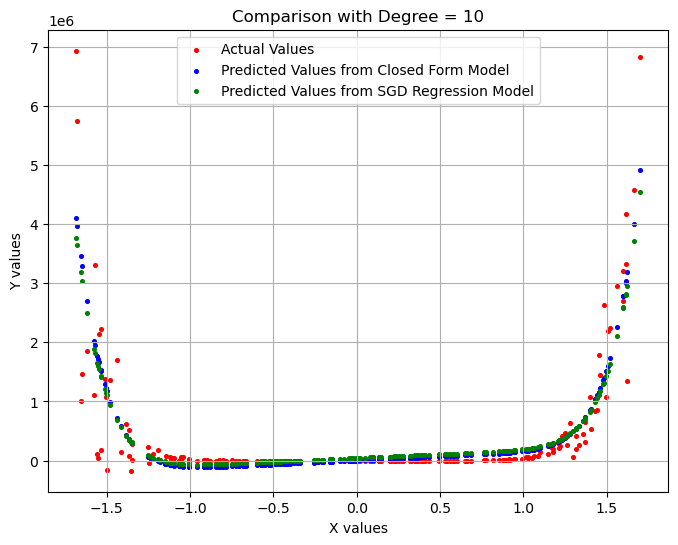

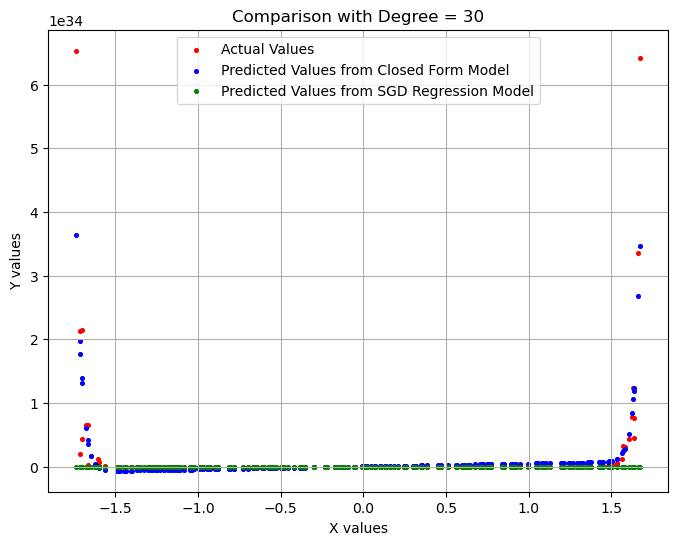

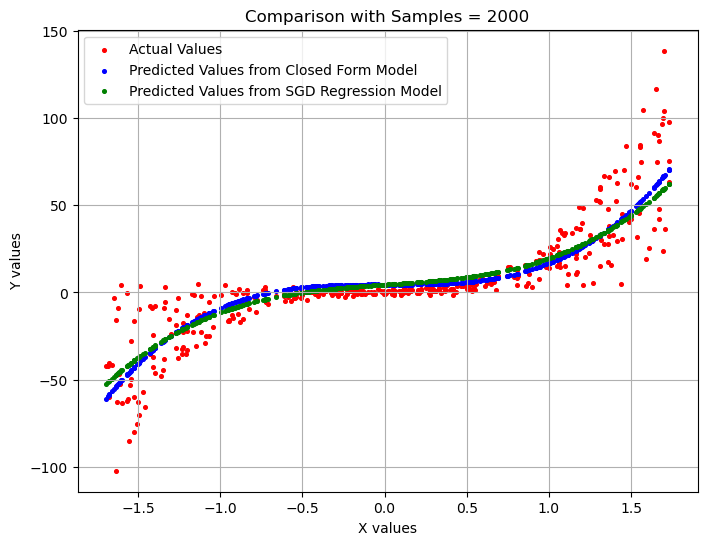

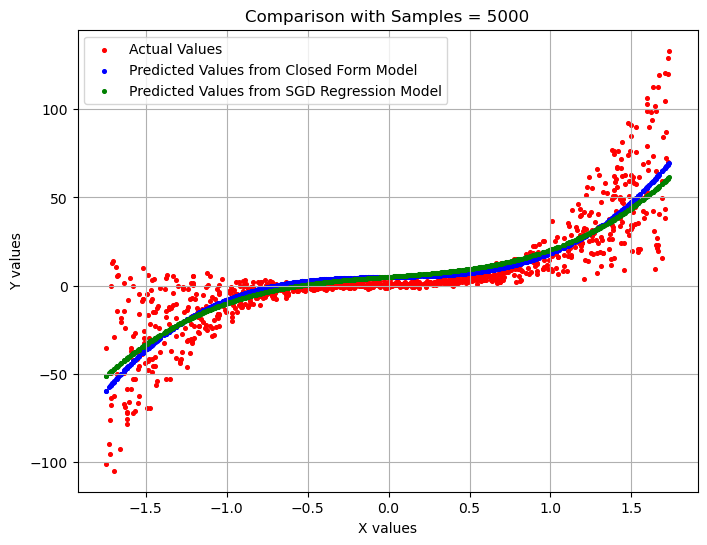

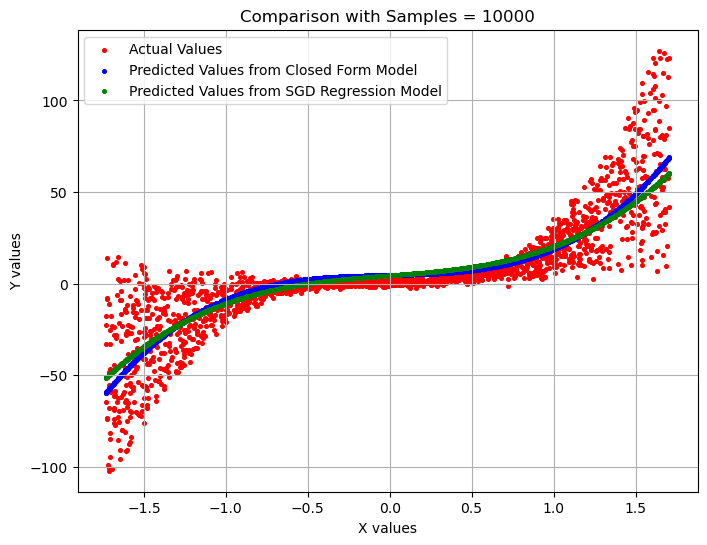

In [562]:
#Prediction and visualisation of all different datasets

for i in range(6):
    reg_cf_model = RidgeRegression_ClosedForm(alpha = 0.1)
    reg_cf_model.train(X_train_list[i], y_train_list[i])
    predicted_y_cf = reg_cf_model.predict(X_test_list[i])

    predicted_y_SGD = predict_SGDReg(X_train_list[i], y_train_list[i], X_test_list[i], 0.1)

    plot_comparison_threeways([X_test_list[i][:,0], y_test_list[i]], [X_test_list[i][:,0], predicted_y_cf], [X_test_list[i][:,0], predicted_y_SGD], 'Closed Form Model','SGD Regression Model',f'Comparison with {dataset_descriptions[i]}')

As can be seen above, the results for the experimental datasets are quite consistent with the results previously observed. Most noticeably, the SGDRegressor seems to over-penalise regularisation and slightly underfit, regardless of the number of samples and regardless of the degree of the dataset. This is particularly evident in the degree=30 set. Due to this, I would suggest that the closed-form based model is overall the better performing model in these trials. <br><br>I would also expect this model to be significantly faster to fit for smaller sized datasets. This model fits through simple application of the closed-form equation, while the SGDRegression needs to repeatedly calculate the derivative, and incremenetally improve potentially hundreds of times (depending on certain parameters), performing thousands of operations to find optimal weights. For this reason the closed form model can be expected to be less computationally intensive and take less time to fit on smaller datasets. However, it is worth noting that the closed-form equation application involves a matrix inversion, which becomes an extremely computationally intensive operation with large datasets. For this reason, SGDRegression could outperform the Closed-form method on sufficiently large sets of data, with both less space and time requirements.

# PART 2: Support Vector Classifier

This part involves construction of a **Support Vector Machine** classification model from nuclear features. This model aims to distinguish forms of breast cytology (malignant or benign) through evaluation of the *Diagnostic Wisconsin Breast Cancer Database1*, from the UC Irvine Machine Learning Repository

In [563]:
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


Helper function for visualising the distribution of different features

In [564]:
def visualise_features(mean, se, worst, features):
    fig, axes = plt.subplots(10, 1, figsize=(6, 30))

    for i in range(10):
        sns.histplot(mean.iloc[:, i], ax=axes[i], color='blue', label='Mean')
        sns.histplot(se.iloc[:, i], ax=axes[i], color='red', label='SE')
        sns.histplot(worst.iloc[:, i], ax=axes[i], color='green', label='Worst')
        
        axes[i].set_title(f'Distribution of {features[i]} ')
        axes[i].set_xlabel(f'{features[i]}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

### Preprocessing of data:

First read the data into a dataframe, and apply the following headings to the column indexes: 
<br>0 = ID: Can be discarded
<br>1 = y array (classifications)
<br>2-11 = Mean values of radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimensions
<br>12-21 = Standard error of values of same 10 fields
<br>22-31 = Worst value of same 10 fields

Then create separate data frames for the mean, standard error and worst fields, and visualise each of them

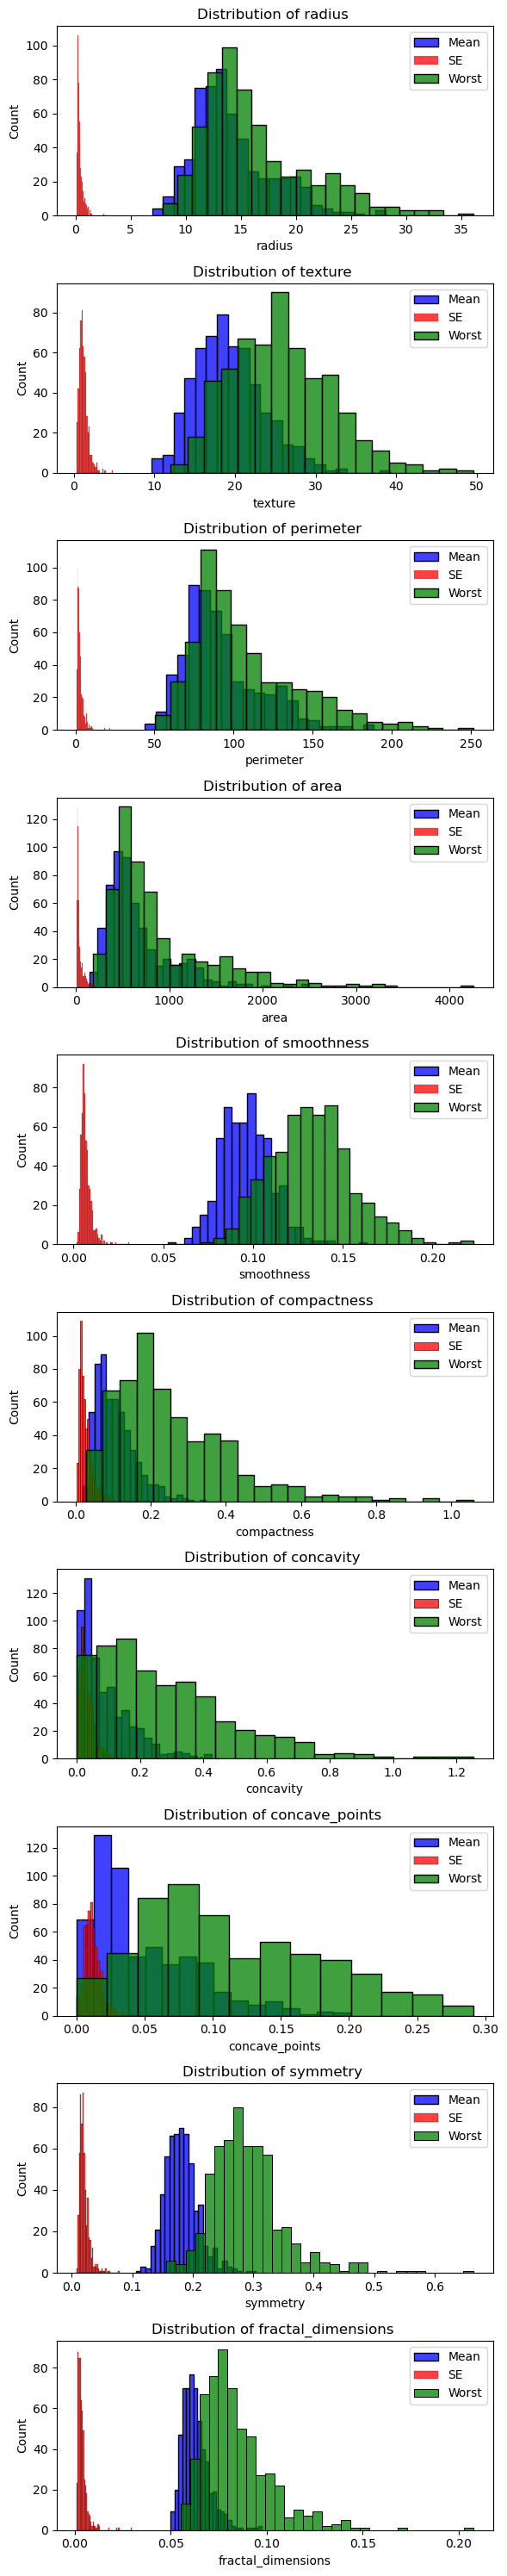

In [565]:
FEATURES = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimensions"]

data = pd.read_csv('data/wdbc.data', header=None)

headings = ['id', 'diagnosis']
for feature_type in ['mean','se','worst']:
    for feature in FEATURES:
        headings.append(feature_type + '_' + feature)

data.columns = headings

data.drop(columns=['id'], inplace=True)

mean_df = data.iloc[:, 1:11]
se_df = data.iloc[:, 11:21]
worst_df = data.iloc[:, 21:31]

visualise_features(mean_df, se_df, worst_df, FEATURES)

Next the data is split into corresponding feature & class pairs, stored in X and y arrays. The data is split 80/20 into training and test data. I initially considered considered ommitting the worst data points, as I thought it may be too anomalous, and incorrectly influence predictions. However, upon comparison on mean + se and mean + se + worst for X, analysis showed that inclusion of worst data points significantly improves the accuracy, so I included it as well as the se and mean data. 

In [566]:
mean = mean_df.values
se = se_df.values
worst = worst_df.values

X = mean + se + worst

X = StandardScaler().fit_transform(X)
y = data.iloc[:, 0].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2) # DO I NEED TO STRATIFY THIS?

The parameter grid is then constructed, using the C regularisation parameter of 4 different values, 4 different forms of kernel, and the option of balanced or no class weighting. A Grid search is then undergone to find the optimal option for the SVC model with a k-fold cross validation (k=5). Once optimal parameters are fit on the training data, they are evaluated on the test set, with accuracy shown below. <br><br>(a) I determined it important to stratify the cross validaiton. Stratified cross validation ensures each fold has a similar class distribution to the whole dataset together. This ensures a reliable indication of performance which is truly representative is achieved<br><br>(b) I opted for the simple 'accuracy' scoring method, which uses sklearn.metrics.accuracy_score function to evaluate performance based on the simple equation of accuracy = correct predictions/total predictions. I determined this metric to make the most sense due to the nature of the binary classification problem. <br><br>(c) In total, 4 * 3 * 2 = 24 different models are fitted, one for each possible combination of hyperparameters. As explained above, I chose to test the hyperparameters C, Kernel Type and Class Weighting option. <br><br> (d) The optimal hyperparameter selections are printed below for 'C', 'kernel' and 'class_weight'. 

In [567]:
parameter_grid = {
    'C': [0.5, 1.0, 3.0, 10.0], # C parameter (regularisation)
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel types
    'class_weight': ['balanced', None] # whether classes should be weighted inversely proporitional to frequency or treated equally
}

svc = SVC(probability=True)
strat_cv = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svc, parameter_grid, cv=strat_cv, scoring='accuracy')
grid_search.fit(train_X, train_y)
optimal_model = grid_search.best_estimator_

print(grid_search.best_params_)

score = optimal_model.score(test_X,test_y)
print(f'ACCURACY: {score}')



{'C': 0.5, 'class_weight': None, 'kernel': 'linear'}
ACCURACY: 0.9824561403508771


Finally, the model with obtained hyperparameters is used to predict the outputs of the test set. The confusion matrix of this is shown below

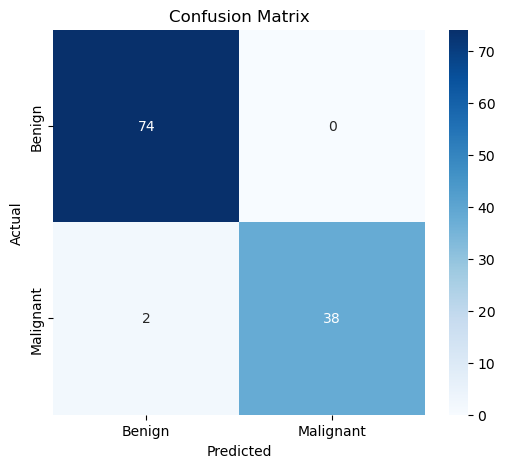

In [568]:
predicted_y = optimal_model.predict(test_X)

confusion = confusion_matrix(test_y, predicted_y)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Although the results of the confusion matrix are quite promising, in its current state, I would not be fully confident deploying this model in real-world cancer screening. Firstly, it would be important to ensure that the precision is improved to reduce unnecessary anxiety and medical costs, but even more important to ensure recall was improved to save lives. I would want the recall to be consistently above 95% before thinking about deploying this model. Next I would want this model to be trained on a greater variety of data. The model has only been trained on a singular dataset, which likely lacks real-world variations of patients and recording situations. The dataset could also be highly curated, and is relatively small to base an entire model off. Finally, in situations of such grave implications such as cancer diagnosis, there should be some level of explainability to a model's decision which is not currently present. The model should be able to provide some interpretable insight into a decision making process.

**Precision Recall** curves would be a useful tool in evaluating the model, particularly with a goal to deploy it in real world cancer detection. These curves allow us to visualise the balance between precision & recall and false positives & false negatives at various threshold values. We could use curves to determine whether the model is or isn't ready to be put into practice in a clinical setting. Below a precision-recall curve is constructed for this model, of which we can obtain several useful pieces of information.

<br> Firstly, the curve has an extremely high area under the curve, suggesting that the model performs quite well at various threshold values.

<br> However, we can also deduce that the model is not up to our standards to be put into use, as threshold values with recall values of 95% and above have relatively low precision of 75% and below.

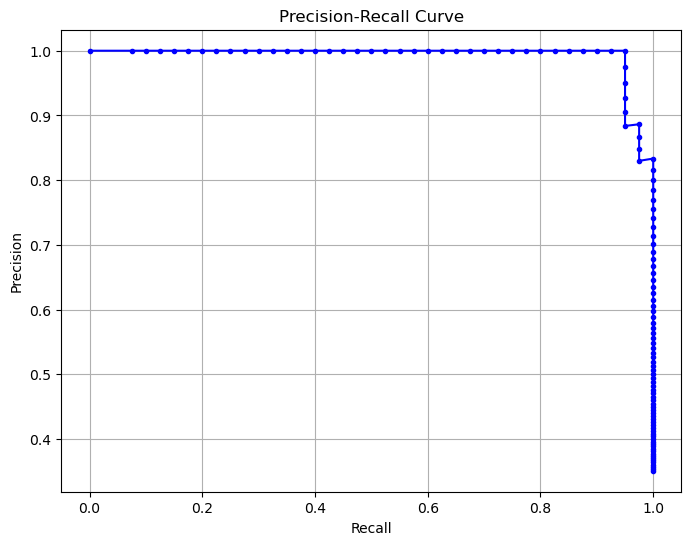

In [569]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class
y_prob = optimal_model.predict_proba(test_X)[:, 1]  # Probabilities for the positive class

# Compute precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(test_y, y_prob, pos_label='M')

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue', label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()